In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from awave.experimental.filters import gabor_filter, edge_filter, curve_filter
from awave.experimental.filters_agg import *
import awave.experimental.viz as viz
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at base filters

In [3]:
filter_size = 13
angle_step = 20
ims = []
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(gabor_filter(filter_size, angle), 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(edge_filter(filter_size, angle)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(edge_filter(filter_size, angle, thickness_cutoff=2)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=1)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=3)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=5)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=9)[0], 0))

100%|██████████| 18/18 [00:00<00:00, 5288.42it/s]


Note the curve filter has a radius parameter which can be easily optimized...


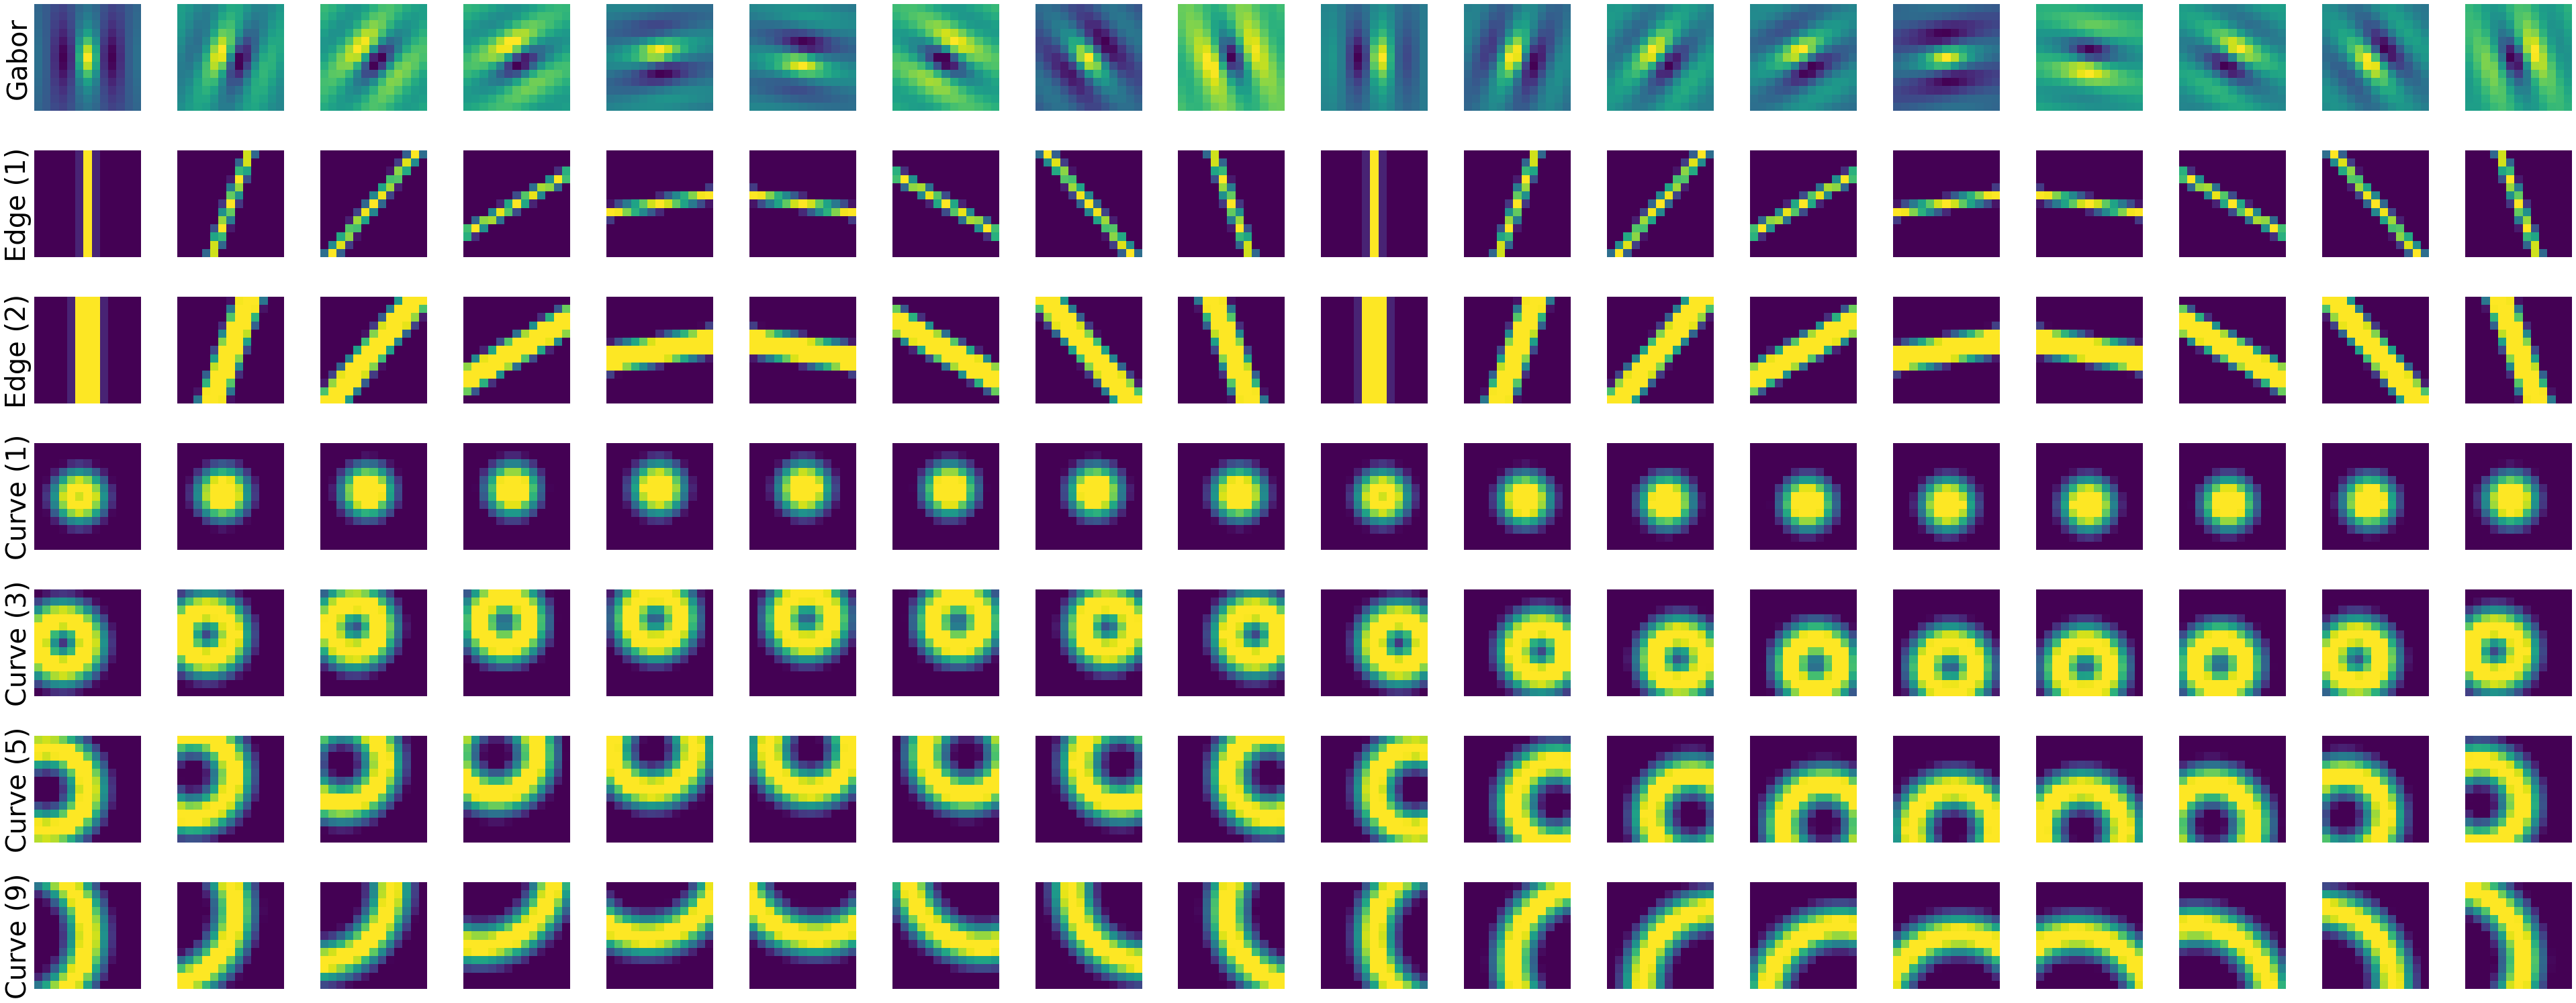

In [4]:
print('Note the curve filter has a radius parameter which can be easily optimized...')
viz.plot_grid(ims, ylabs=['Gabor', 'Edge (1)', 'Edge (2)',
                          'Curve (1)', 'Curve (3)', 'Curve (5)', 'Curve (9)'], fontsize_ylab=40)

# stitch together base filters

In [5]:
input_spec    = [("color", i) for i in range(3)]
conv2d0_spec  = [("gabor", orientation,  offset)
                 for orientation in range(0, 180, 10)
                 for offset in [0, 7./8., 7./4, 7.*3/8.]]
conv2d1_spec  = [("edge", orientation) for orientation in range(0, 180, 10) ]

conv2d2_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
conv2d2_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

mixed3a_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
mixed3a_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

mixed3b_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
mixed3b_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

In [18]:
# these are the weights that connect one layer to the next
W_conv2d0 = make_weights(7, input_spec, conv2d0_spec)
W_conv2d1 = make_weights(1, conv2d0_spec, conv2d1_spec)
W_conv2d2 = make_weights(3, conv2d1_spec, conv2d2_spec, r=list(range(5,10)))
W_mixed3a = make_weights(3, conv2d2_spec, mixed3a_spec, r=list(range(4,10)))
W_mixed3b = make_weights(5, mixed3a_spec, mixed3b_spec, r=list(range(4,10)))

In [19]:
print(W_conv2d0.shape, W_conv2d1.shape, W_conv2d2.shape, W_mixed3a.shape, W_mixed3b.shape)

(7, 7, 3, 72) (1, 1, 72, 18) (3, 3, 18, 42) (3, 3, 42, 42) (5, 5, 42, 42)


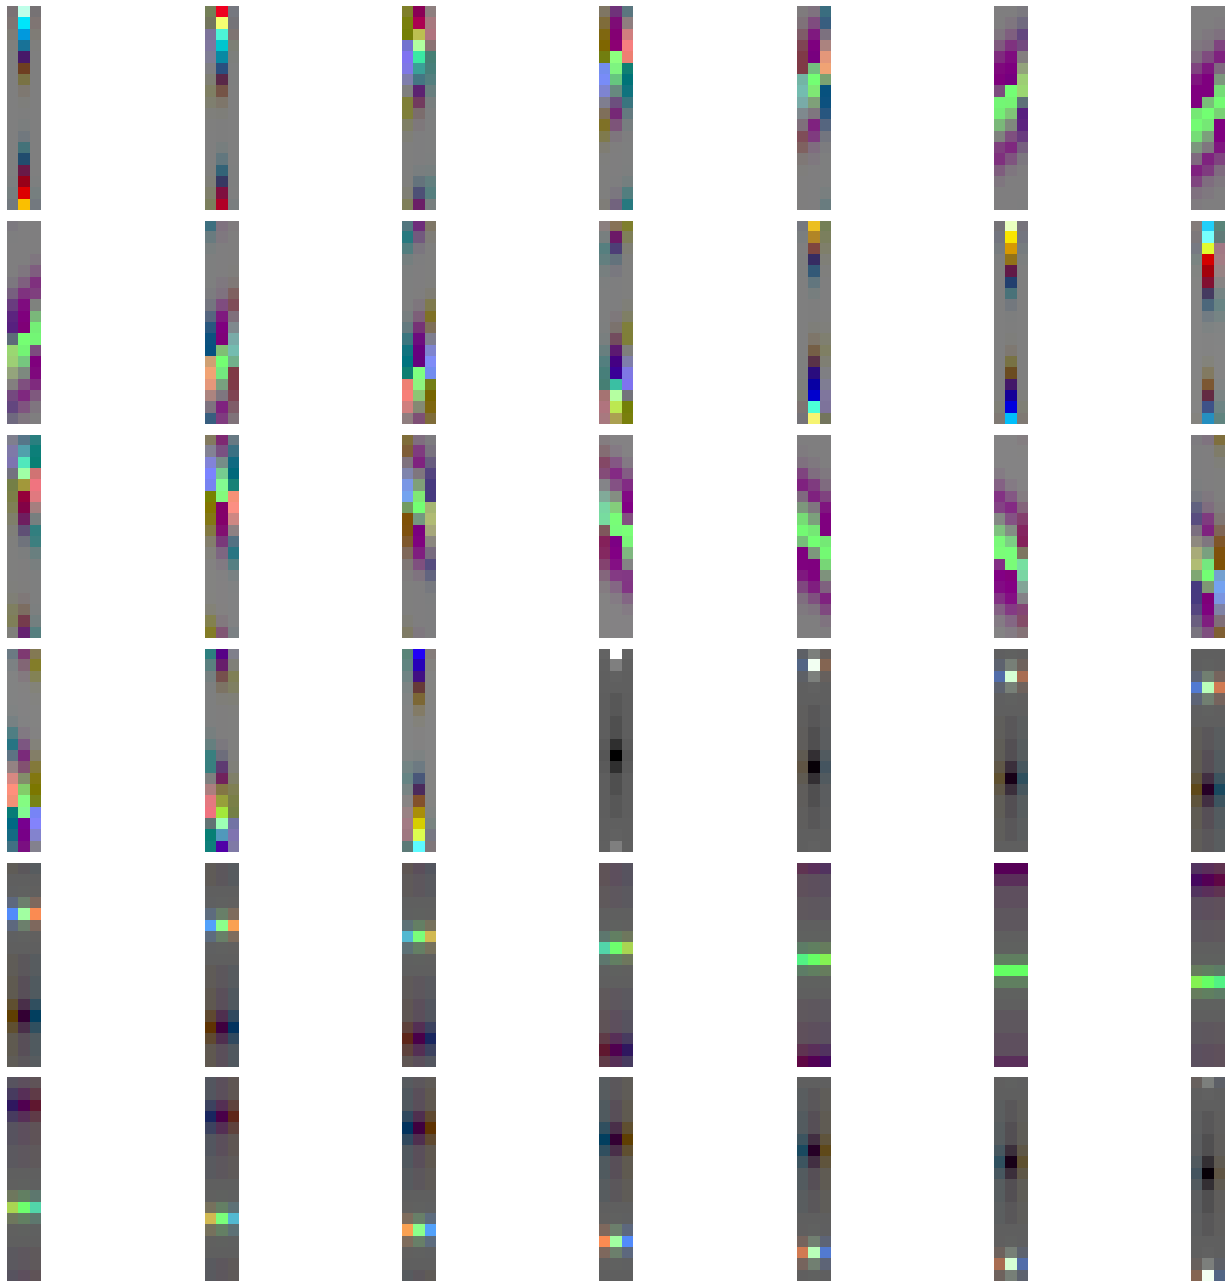

In [30]:
viz.plot_grid(W_conv2d2.transpose())

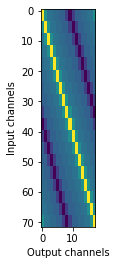

In [24]:
plt.imshow(W_conv2d1.squeeze())
plt.ylabel('Input channels')
plt.xlabel('Output channels')
plt.show()

# Extract features and fit linear model

In [13]:
import cifar10
from torch import nn
import torch
import torch.optim as optim
import util

W_conv2d0 = make_weights(7, 
                         [("color", i) for i in range(3)], 
                         [("gabor", orientation,  offset)
                          for orientation in range(0, 180, 10)
                          for offset in [0, 7./8., 7./4, 7.*3/8.]]
                        )
conv2d0 = nn.Conv2d(in_channels=3, out_channels=W_conv2d0.shape[-1], kernel_size=W_conv2d0.shape[0])
conv2d0.weight.value = torch.Tensor(W_conv2d0.transpose())
conv2d0.bias.value = 0
pool2d0 = nn.MaxPool2d(kernel_size=5, stride=4, padding=0)
feat_extractor = nn.Sequential(conv2d0, pool2d0)
    

conv2d0 = nn.Conv2d(in_channels=3, out_channels=W_conv2d0.shape[-1], kernel_size=W_conv2d0.shape[0])
conv2d0.weight.value = torch.Tensor(W_conv2d0.transpose())
conv2d0.bias.value = 0
pool2d0 = nn.MaxPool2d(kernel_size=4, stride=2, padding=0)

**look at one example**

In [39]:
x, y = cifar10.get_batch(batch_size=1) # X is 1, 3, 32, 32

# x.shape
# x0 = x[0].detach().numpy().transpose()
# plt.imshow((x0 - x0.min()) / (x0.max() - x0.min()), interpolation='bilinear')
# plt.show()

x_gabor = conv2d0(x) # 72, 26, 26
x_gabor_pooled = pool2d0(x_gabor) # 72, 12, 12

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
viz.plot_grid(np.expand_dims(x_gabor_pooled.detach().numpy()[0], 1))

# (tf) set up architecture based on these weights

In [ ]:
t_image = tf.placeholder("float32", [None, None, None, 3], name="input")

t_conv2d0 = tf.nn.conv2d(t_image, W_conv2d0, strides=[2,2], padding="SAME")
t_conv2d0 = tf.nn.relu(t_conv2d0, name="conv2d0")

t_conv2d0_pool = tf.nn.max_pool2d(t_conv2d0, [3,3], strides=[2,2], padding="SAME")

t_conv2d1 = tf.nn.conv2d(t_conv2d0_pool, W_conv2d1, strides=[1,1], padding="SAME")
t_conv2d1 = tf.nn.relu(t_conv2d1, name="conv2d1")

t_conv2d2 = tf.nn.conv2d(t_conv2d1, W_conv2d2, strides=[1,1], padding="SAME")
t_conv2d2 = tf.nn.relu(t_conv2d2, name="conv2d2")

t_conv2d2_pool = tf.nn.max_pool2d(t_conv2d2, [3,3], strides=[2,2], padding="SAME")

t_mixed3a = tf.nn.conv2d(t_conv2d2_pool, W_mixed3a, strides=[1,1], padding="SAME")
t_mixed3a = tf.nn.relu(t_mixed3a, name="mixed3a")

t_mixed3b = tf.nn.conv2d(t_mixed3a, W_mixed3b, strides=[1,1], padding="SAME")
t_mixed3b = tf.nn.relu(t_mixed3b, name="mixed3b")

In [36]:
a = [1,2]

In [37]:
type(a)

list

In [41]:
str(type(1))

"<class 'int'>"

In [63]:
a = [[2,[2,[2]]],3,[4,[5,6]]]

In [64]:
a = list(reversed(a))

In [65]:
a


[[4, [5, 6]], 3, [2, [2, [2]]]]

In [66]:
a.extend(reversed(a.pop()))

In [67]:
a

[[4, [5, 6]], 3, [2, [2]], 2]

In [68]:
"list" in str(type(a[-1]))

False

In [51]:
a.pop().getList()

AttributeError: 'int' object has no attribute 'getList'

In [ ]:
class hi():

In [54]:
class NestedIterator():
    
    def __init__(self, nestedList):
        self.stack = list(reversed(nestedList))
        
        
    def next(self) -> int:
        self.make_stack_top_an_integer()
        return self.stack.pop().getInteger()
    
        
    def hasNext(self) -> bool:
        self.make_stack_top_an_integer()
        return len(self.stack) > 0
        
        
    def make_stack_top_an_integer(self):
        # While the stack contains a nested list at the top...
        while self.stack and not self.stack[-1].isInteger():
            # Unpack the list at the top by putting its items onto
            # the stack in reverse order.
            self.stack.extend(reversed(self.stack.pop().getList()))

In [56]:
b = NestedIterator(a)

In [57]:
b.next()

AttributeError: 'list' object has no attribute 'isInteger'

In [ ]:
a.extend(reversed(a.stack.pop().getList()))

In [72]:
nums = [3,30,34,5,9]

In [78]:
def compare(x, y):
    return str(x)+str(y) > str(y)+str(x)

In [81]:
sorted(nums, key=compare())

TypeError: compare() missing 2 required positional arguments: 'x' and 'y'

In [83]:
list(map(str, nums))

['3', '30', '34', '5', '9']

In [ ]:
class compare():
    

In [77]:
sorted(nums, key=lambda x: str(x)[0])[::-1]

[9, 5, 34, 30, 3]

In [ ]:
class LargerNumKey(str):
    def __lt__(x, y):
        return x+y > y+x
        
class Solution:
    def largestNumber(self, nums):
        largest_num = ''.join(sorted(map(str, nums), key=LargerNumKey))
        return '0' if largest_num[0] == '0' else largest_num

In [71]:
nums

[3, 5, 9, 30, 34]